# Imports

In [1]:
import os
import tarfile
from scipy.io import loadmat
from PIL import Image

# PyTorch
import torch
from torch import cuda
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Torchvision
from torchvision import transforms, utils as torchvision_utils, models
from torchvision.models import vgg19, VGG19_Weights
from torchsummary import summary

# Data Splitting and Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Visualization
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Extract the dataset
tgz_file = r"./102flowers.tgz"  # Replace with the path to your downloaded file
extract_path = "flowers102"

with tarfile.open(tgz_file, "r:gz") as tar:
    tar.extractall(path=extract_path)

print("Dataset extracted!")


Dataset extracted!


## Loading the labels

In [2]:

# Load the labels
annotations = loadmat(fr"./imagelabels.mat")
labels = annotations['labels'][0]
print(f"Total labels: {len(labels)}")


Total labels: 8189


## Rented a GPU on vast.ai to save time, using CUDA

In [3]:

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. GPUs are ready to use!")
else:
    print("CUDA is not available. Training will use the CPU.")

print(f"GPU's {cuda.get_device_name(0),cuda.get_device_name(1)}")


CUDA is available. GPUs are ready to use!
GPU's ('NVIDIA RTX A4000', 'NVIDIA RTX A4000')


# Dataset Preparation

In [4]:

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Custom Dataset
class Flowers102Dataset(Dataset):
    def __init__(self, img_dir, labels, indices, transform=None):
        self.img_dir = img_dir
        self.labels = labels
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"image_{self.indices[idx]:05d}.jpg")
        image = Image.open(img_path).convert("RGB")
        label = self.labels[self.indices[idx] - 1] - 1  # Convert to 0-based index
        if self.transform:
            image = self.transform(image)
        return image, label

# Split data
image_indices = list(range(1, len(labels) + 1))
train_idx, test_val_idx = train_test_split(image_indices, test_size=0.5, random_state=42)
val_idx, test_idx = train_test_split(test_val_idx, test_size=0.5, random_state=42)

# Create datasets
data_dir = f"{extract_path}/jpg"
train_dataset = Flowers102Dataset(data_dir, labels, train_idx, transform)
val_dataset = Flowers102Dataset(data_dir, labels, val_idx, transform)
test_dataset = Flowers102Dataset(data_dir, labels, test_idx, transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


# Visualize a sample of the images

In [7]:

# Function to display a grid of images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # Convert to HWC format for displaying
    mean = np.array([0.485, 0.456, 0.406])  # Mean used during normalization
    std = np.array([0.229, 0.224, 0.225])   # Std deviation used during normalization
    inp = std * inp + mean  # Denormalize the image
    inp = np.clip(inp, 0, 1)  # Clip to valid range [0, 1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Remove axes for cleaner visualization
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(test_loader))

# Make a grid from batch
out = torchvision_utils.make_grid(inputs)

# Define class names (replace with your actual class names if available)
class_names = [f"Class {i}" for i in range(102)]  # Assuming 102 classes

# Show images
# imshow(out, title=[class_names[x] for x in classes])



In [6]:
# Early Stopping With Patience Mechanism
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.best_model = None

    def step(self, loss, model):
        if loss < self.best_loss:
            self.best_loss = loss
            self.counter = 0
            self.best_model = model.state_dict()
            return True
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return False
            return True
        
# Training Loop + Validation Loop + Running Test at the end
def train_model(model, train_loader, val_loader, test_loader, num_epochs=10):
    best_accuracy = 0
    early_stopping = EarlyStopping(patience=3)

    # Track losses and accuracies
    train_losses, val_losses, test_losses = [], [], []
    train_accuracies, val_accuracies, test_accuracies = [], [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # Training phase
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_accuracies.append(val_accuracy)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_model.pth")

        # Early stopping
        if not early_stopping.step(val_loss, model):
            print("Early stopping triggered")
            break

    # Test phase
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    test_loss = 0.0
    test_preds, test_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Return all metrics
    return train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies




In [7]:

def plot_training_metrics(epochs, train_losses, val_losses, test_losses=None, 
                          train_accuracies=None, val_accuracies=None, test_accuracies=None):
    """
    Plots training metrics including loss and accuracy for training, validation, and test phases.
    
    Args:
        epochs (list or range): The range of epochs.
        train_losses (list): List of training loss values.
        val_losses (list): List of validation loss values.
        test_losses (list, optional): List of test loss values.
        train_accuracies (list, optional): List of training accuracy values.
        val_accuracies (list, optional): List of validation accuracy values.
        test_accuracies (list, optional): List of test accuracy values.
    """
    # Plot Losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    if test_losses:
        plt.plot(epochs, test_losses, label="Test Loss", linestyle='--')
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot Accuracies if provided
    if train_accuracies and val_accuracies:
        plt.figure()
        plt.plot(epochs, train_accuracies, label="Training Accuracy")
        plt.plot(epochs, val_accuracies, label="Validation Accuracy")
        if test_accuracies:
            plt.plot(epochs, test_accuracies, label="Test Accuracy", linestyle='--')
        plt.title("Accuracy over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()





In [5]:

model = torch.hub.load('ultralytics/yolov5', 'custom', path='./weights/yolov5s-cls.pt')

# Inspect the model architecture to locate the classification layer
print(model.model)

# Update the final classification layer
num_classes = 102  # Replace with your number of classes
if hasattr(model.model.model[-1], 'linear'):  # Check if the last layer has a 'linear' attribute
    model.model.model[-1].linear = torch.nn.Linear(
        model.model.model[-1].linear.in_features, num_classes
    )
else:
    raise ValueError("Could not find the final classification layer. Inspect the model architecture.")

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Provide input size (e.g., 3x224x224 for an RGB image)
summary(model, input_size=(3, 224, 224))
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-1-6 Python-3.10.13 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16109MiB)

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
WARNING ⚠️ YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


ClassificationModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (2): C3(
      (cv1): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv3): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (m): Sequential(
        (0): Bottleneck(
          (cv1): Conv(
            (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

# Finetuning YOLOv5

In [8]:
# Run training
train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies = train_model(
    model, train_loader, val_loader, test_loader, num_epochs=20
)



Epoch 1/20
--------------------


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s]


Train Loss: 1.8093, Train Accuracy: 0.6187
Val Loss: 0.6569, Val Accuracy: 0.8510
Epoch 2/20
--------------------


Validation: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]


Train Loss: 0.2863, Train Accuracy: 0.9443
Val Loss: 0.4028, Val Accuracy: 0.9126
Epoch 3/20
--------------------


Validation: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s]


Train Loss: 0.1346, Train Accuracy: 0.9868
Val Loss: 0.3708, Val Accuracy: 0.9170
Epoch 4/20
--------------------


Validation: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s]


Train Loss: 0.0816, Train Accuracy: 0.9954
Val Loss: 0.3496, Val Accuracy: 0.9194
Epoch 5/20
--------------------


Validation: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s]


Train Loss: 0.0531, Train Accuracy: 0.9993
Val Loss: 0.3268, Val Accuracy: 0.9243
Epoch 6/20
--------------------


Validation: 100%|██████████| 16/16 [00:13<00:00,  1.14it/s]


Train Loss: 0.0395, Train Accuracy: 0.9995
Val Loss: 0.3189, Val Accuracy: 0.9194
Epoch 7/20
--------------------


Validation: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s]


Train Loss: 0.0299, Train Accuracy: 1.0000
Val Loss: 0.3084, Val Accuracy: 0.9238
Epoch 8/20
--------------------


Validation: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s]


Train Loss: 0.0243, Train Accuracy: 1.0000
Val Loss: 0.3013, Val Accuracy: 0.9238
Epoch 9/20
--------------------


Validation: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s]


Train Loss: 0.0203, Train Accuracy: 1.0000
Val Loss: 0.3041, Val Accuracy: 0.9277
Epoch 10/20
--------------------


Validation: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s]


Train Loss: 0.0173, Train Accuracy: 1.0000
Val Loss: 0.2955, Val Accuracy: 0.9248
Epoch 11/20
--------------------


Validation: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s]


Train Loss: 0.0148, Train Accuracy: 1.0000
Val Loss: 0.2923, Val Accuracy: 0.9267
Epoch 12/20
--------------------


Validation: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s]


Train Loss: 0.0130, Train Accuracy: 1.0000
Val Loss: 0.2919, Val Accuracy: 0.9257
Epoch 13/20
--------------------


Validation: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s]


Train Loss: 0.0114, Train Accuracy: 1.0000
Val Loss: 0.2907, Val Accuracy: 0.9272
Epoch 14/20
--------------------


Validation: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s]


Train Loss: 0.0103, Train Accuracy: 1.0000
Val Loss: 0.2884, Val Accuracy: 0.9277
Epoch 15/20
--------------------


Validation: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


Train Loss: 0.0092, Train Accuracy: 1.0000
Val Loss: 0.2878, Val Accuracy: 0.9277
Epoch 16/20
--------------------


Validation: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s]


Train Loss: 0.0084, Train Accuracy: 1.0000
Val Loss: 0.2859, Val Accuracy: 0.9301
Epoch 17/20
--------------------


Validation: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s]


Train Loss: 0.0076, Train Accuracy: 1.0000
Val Loss: 0.2855, Val Accuracy: 0.9287
Epoch 18/20
--------------------


Validation: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s]


Train Loss: 0.0069, Train Accuracy: 1.0000
Val Loss: 0.2828, Val Accuracy: 0.9297
Epoch 19/20
--------------------


Validation: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s]


Train Loss: 0.0064, Train Accuracy: 1.0000
Val Loss: 0.2839, Val Accuracy: 0.9272
Epoch 20/20
--------------------


Validation: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s]


Train Loss: 0.0059, Train Accuracy: 1.0000
Val Loss: 0.2806, Val Accuracy: 0.9297


Testing: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s]

Test Loss: 0.2517, Test Accuracy: 0.9302


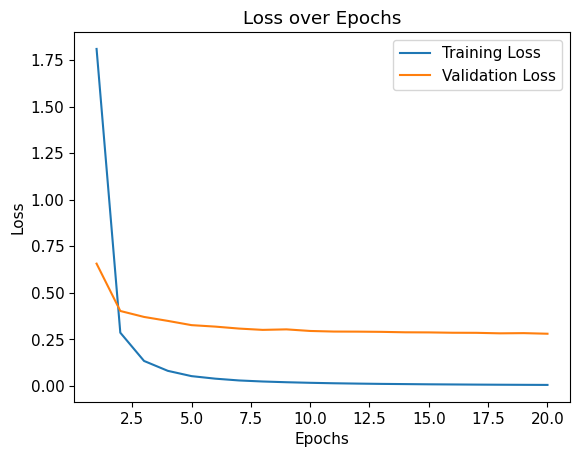

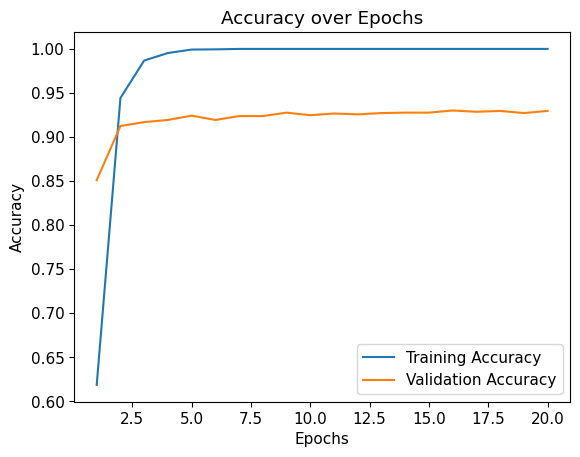

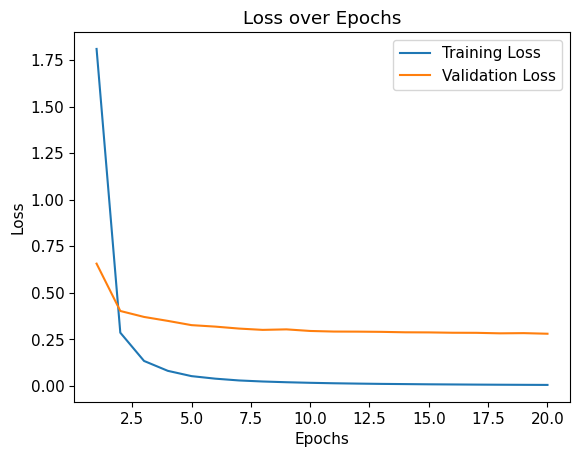

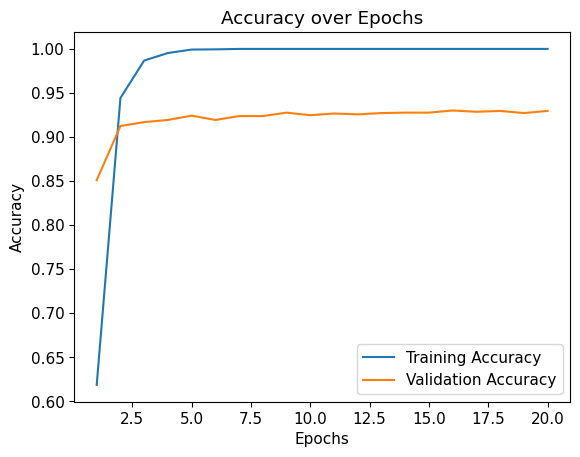

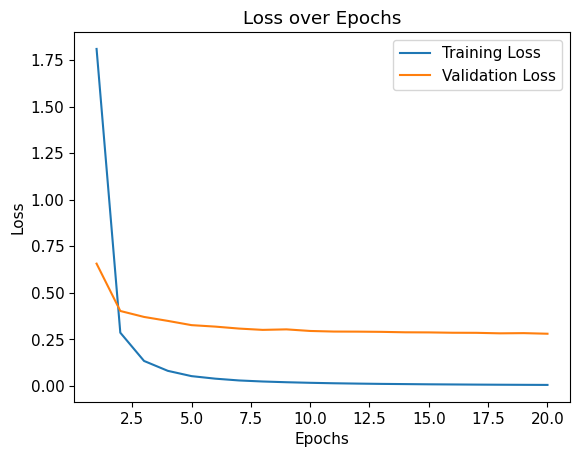

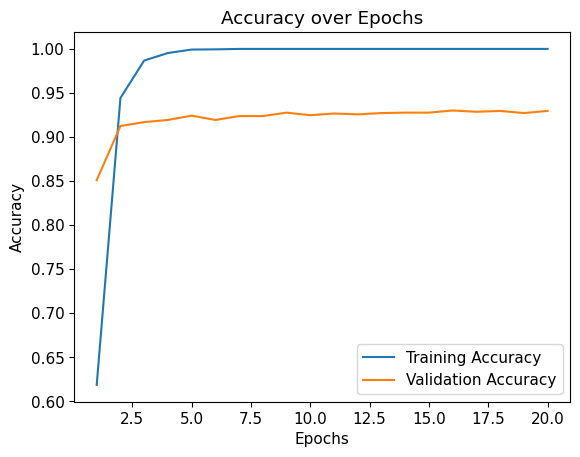

In [12]:
%matplotlib inline
# Generate the range of epochs
epochs = range(1, len(train_losses) + 1)

# Call the plotting function
plot_training_metrics(
    epochs=epochs,
    train_losses=train_losses,
    val_losses=val_losses,
    train_accuracies=train_accuracies,
    val_accuracies=val_accuracies,
)

# Using a pretrained VGG19 for fine-tuning

In [13]:
import torch
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from torchvision.models import vgg19, VGG19_Weights

# Load pretrained VGG19
model = vgg19(weights=VGG19_Weights.DEFAULT)

# Modify the classifier to match the number of classes
num_classes = 102  # Total flower categories
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all parameters

# Unfreeze the last layer (classifier[6])
for param in model.classifier[6].parameters():
    param.requires_grad = True  # Unfreeze only the last layer

# Transfer model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print summary of trainable parameters
print("Trainable layers:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

Trainable layers:
classifier.6.weight
classifier.6.bias


Epoch 1/20
--------------------


Validation: 100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


Train Loss: 2.5936, Train Accuracy: 0.4411
Val Loss: 1.2559, Val Accuracy: 0.6766
Epoch 2/20
--------------------


Validation: 100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


Train Loss: 0.9761, Train Accuracy: 0.7284
Val Loss: 1.0274, Val Accuracy: 0.7367
Epoch 3/20
--------------------


Validation: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.7420, Train Accuracy: 0.7863
Val Loss: 1.0111, Val Accuracy: 0.7445
Epoch 4/20
--------------------


Validation: 100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


Train Loss: 0.6634, Train Accuracy: 0.8026
Val Loss: 0.9847, Val Accuracy: 0.7548
Epoch 5/20
--------------------


Validation: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Train Loss: 0.5696, Train Accuracy: 0.8307
Val Loss: 0.9318, Val Accuracy: 0.7577
Epoch 6/20
--------------------


Validation: 100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


Train Loss: 0.5521, Train Accuracy: 0.8363
Val Loss: 0.9410, Val Accuracy: 0.7572
Epoch 7/20
--------------------


Validation: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Train Loss: 0.5116, Train Accuracy: 0.8512
Val Loss: 0.9555, Val Accuracy: 0.7665
Epoch 8/20
--------------------


Validation: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


Train Loss: 0.4139, Train Accuracy: 0.8745
Val Loss: 0.9432, Val Accuracy: 0.7650
Early stopping triggered


Testing: 100%|██████████| 16/16 [00:18<00:00,  1.15s/it]

Test Loss: 0.9006, Test Accuracy: 0.7754


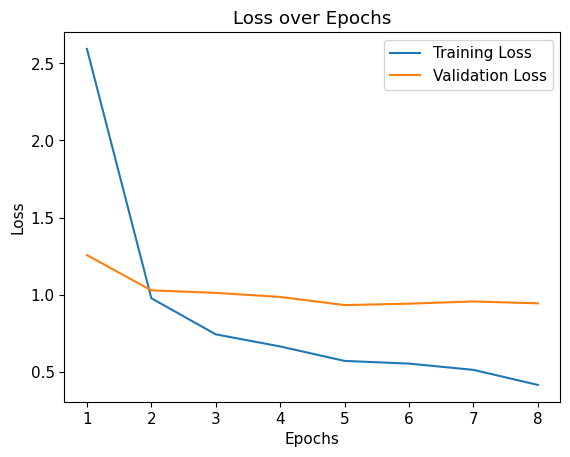

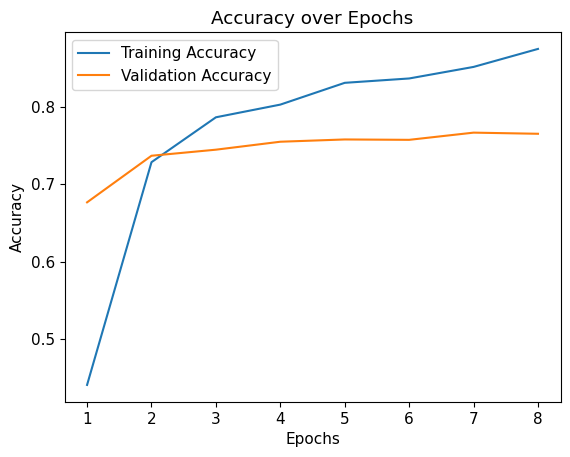

In [14]:
# Run training
train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accuracies = train_model(
    model, train_loader, val_loader, test_loader, num_epochs=20
)
# Generate the range of epochs
epochs = range(1, len(train_losses) + 1)

# Call the plotting function
plot_training_metrics(
    epochs=epochs,
    train_losses=train_losses,
    val_losses=val_losses,
    train_accuracies=train_accuracies,
    val_accuracies=val_accuracies,
)
